In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
%matplotlib inline
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15) 

In [2]:
dotenv_path = "../.env"
load_dotenv(dotenv_path)

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

conn = mysql.connector.connect(
    host = db_host,
    port = db_port,
    database = db_name,
    user = db_user,
    password = db_password
)

mycursor = conn.cursor()

def show_sql_result(sql):
       mycursor.execute(sql)
       rows = mycursor.fetchall()
       columns = [column[0] for column in mycursor.description]
       table_data = pd.DataFrame(rows, columns=columns)
       return table_data

## 고객 특성 컬럼 생성

#### 평균 구매 간격

In [3]:
sql = '''
SELECT
    CustomerID,
    COUNT(DISTINCT TransactionID) AS 구매횟수,
    AVG(NULLIF(구매간격, 0)) AS 평균구매간격,
    DATEDIFF('2019-12-31', MAX(TransactionDate)) + 1 AS Recency
FROM(
    SELECT
        CustomerID,
        TransactionID,
        TransactionDate,
        CASE 
            WHEN DATEDIFF(LEAD(TransactionDate) OVER (PARTITION BY CustomerID ORDER BY TransactionDate), TransactionDate) = 0 THEN 0
            ELSE DATEDIFF(LEAD(TransactionDate) OVER (PARTITION BY CustomerID ORDER BY TransactionDate), TransactionDate)
        END AS 구매간격
    FROM
        sales
    WHERE
        TransactionID IN (SELECT DISTINCT TransactionID FROM sales)
) AS CustomerSales
GROUP BY 
    CustomerID
;
'''

show_sql_result(sql)
buy_interval = show_sql_result(sql)
buy_interval

,CustomerID,구매횟수,평균구매간격,Recency
0,USER_0000,1,None,108
1,USER_0001,31,111.5000,60
2,USER_0002,8,119.0000,74
3,USER_0003,11,None,18
4,USER_0004,13,None,108
...,...,...,...,...
1463,USER_1463,3,None,271
1464,USER_1464,19,52.5000,88
1465,USER_1465,2,76.0000,195
1466,USER_1466,1,None,70


- 구매가 발생한 날짜가 하루면 None으로 처리되었음

In [4]:
buy_interval[buy_interval['평균구매간격'].notnull()]

,CustomerID,구매횟수,평균구매간격,Recency
1,USER_0001,31,111.5000,60
2,USER_0002,8,119.0000,74
6,USER_0006,44,30.0000,190
8,USER_0008,37,139.0000,41
9,USER_0009,39,24.0000,100
...,...,...,...,...
1459,USER_1459,27,150.5000,35
1460,USER_1460,30,73.5000,34
1464,USER_1464,19,52.5000,88
1465,USER_1465,2,76.0000,195


In [5]:
buy_interval.loc[(buy_interval['평균구매간격'].isnull())&(buy_interval['구매횟수']>1)]

,CustomerID,구매횟수,평균구매간격,Recency
3,USER_0003,11,None,18
4,USER_0004,13,None,108
5,USER_0005,3,None,131
7,USER_0007,5,None,25
11,USER_0011,10,None,115
...,...,...,...,...
1450,USER_1450,17,None,24
1451,USER_1451,21,None,109
1461,USER_1461,6,None,19
1462,USER_1462,2,None,180


- 구매 건수가 1건 이상인데도 모든 거래가 하루에 발생한 고객들이 있음 
    - 이상거래?
    - 구매 대행 혹은 도매업자

In [6]:
sql = '''
SELECT
    *
FROM
    sales
;
'''

sales = show_sql_result(sql)
sales[sales['CustomerID'] == 'USER_1451']

,CustomerID,TransactionID,TransactionDate,ProductID,ProductCategory,Quantity,AverageAmount,ShippingFee,CouponStatus
19845,USER_1451,Transaction_16833,2019-09-14,Product_0848,Bags,5,12.79,25.73,Not Used
19846,USER_1451,Transaction_16833,2019-09-14,Product_0900,Drinkware,30,10.39,25.73,Used
19847,USER_1451,Transaction_16834,2019-09-14,Product_0983,Nest-USA,1,119.00,6.00,Not Used
19848,USER_1451,Transaction_16835,2019-09-14,Product_0983,Nest-USA,2,119.00,6.00,Used
19849,USER_1451,Transaction_16836,2019-09-14,Product_0563,Apparel,1,27.50,6.00,Clicked
19850,USER_1451,Transaction_16836,2019-09-14,Product_0900,Drinkware,1,12.99,6.00,Used
19851,USER_1451,Transaction_16836,2019-09-14,Product_0904,Office,3,2.99,6.00,Clicked
19852,USER_1451,Transaction_16836,2019-09-14,Product_0905,Office,2,2.99,6.00,Clicked
19853,USER_1451,Transaction_16837,2019-09-14,Product_0870,Lifestyle,45,1.99,6.00,Clicked
19854,USER_1451,Transaction_16838,2019-09-14,Product_0870,Lifestyle,46,1.99,6.00,Used


In [7]:
sql = '''
SELECT
    *
FROM
    rfm
;
'''

rfm = show_sql_result(sql)
rfm[rfm['CustomerID'] == 'USER_1451']

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Class
1451,USER_1451,109,21,2803.25,3,4,4,344,11,Platinum


- USER_1451은 최근 거래기록은 없지만 거래 건수가 많고 거래 금액도 큰 우수 고객으로 분류(RFM_Score 11, Platinum)
- 하지만 USER_1451은 단 하루의 거래 기록만 있음

> 우수 고객의 정의?
- 10건의 거래를 하루에 한 고객 vs. 1건씩 10일을 거래한 고객
- 전자에 해당하는 고객이 구매 금액이 클 가능성이 높음. 개인보다는 조직일 가능성이 높음. 별도로 분류하고 특별한 마케팅 전략을 수립
    - 대량 구매 혜택, 볼륨 할인
    - 특별한 이벤트나 목적을 위한 구매일 가능성 : 구매 동기에 따라 제안된 마케팅의 반응도가 크게 달라질 수 있음
- 후자처럼 장기간 지속적으로 거래하는 고객은 금액이 작더라도 충성도가 높고 재구매 가능성이 높다고 평가할 수 있음
    - 충성도 프로그램, 개인화 서비스 제공
    - 새로운 제품 출시나 프로모션에 더 적극적으로 반응할 가능성
    - 지속적인 구매 이력을 바탕으로 보다 정확한 맞춤형 마케팅 수행 가능 -> 더 정확한 고객 세그먼트. 고객 분류에 대한 신뢰성 높음

In [8]:
sales[sales['CustomerID'] == 'USER_0004']

,CustomerID,TransactionID,TransactionDate,ProductID,ProductCategory,Quantity,AverageAmount,ShippingFee,CouponStatus
19985,USER_0004,Transaction_16887,2019-09-15,Product_1046,Apparel,1,11.89,6.00,Used
19986,USER_0004,Transaction_16888,2019-09-15,Product_0900,Drinkware,1,10.39,6.50,Clicked
19987,USER_0004,Transaction_16889,2019-09-15,Product_0352,Apparel,1,28.00,6.00,Clicked
19988,USER_0004,Transaction_16889,2019-09-15,Product_0990,Nest,1,199.00,6.00,Used
19990,USER_0004,Transaction_16890,2019-09-15,Product_0976,Nest-USA,2,119.00,12.99,Not Used
19991,USER_0004,Transaction_16891,2019-09-15,Product_0981,Nest-USA,1,149.00,6.00,Clicked
19992,USER_0004,Transaction_16892,2019-09-15,Product_0095,Apparel,1,12.00,6.00,Not Used
19993,USER_0004,Transaction_16892,2019-09-15,Product_0457,Apparel,1,16.79,6.00,Clicked
19994,USER_0004,Transaction_16892,2019-09-15,Product_0542,Apparel,1,4.80,6.00,Not Used
19995,USER_0004,Transaction_16892,2019-09-15,Product_0560,Apparel,1,9.60,6.00,Clicked


In [9]:
sales[sales['CustomerID'] == 'USER_0011']

,CustomerID,TransactionID,TransactionDate,ProductID,ProductCategory,Quantity,AverageAmount,ShippingFee,CouponStatus
19025,USER_0011,Transaction_16489,2019-09-08,Product_0984,Nest-USA,1,79.00,6.00,Clicked
19027,USER_0011,Transaction_16490,2019-09-08,Product_0284,Apparel,1,13.59,6.00,Not Used
19028,USER_0011,Transaction_16491,2019-09-08,Product_0274,Apparel,1,19.99,6.00,Clicked
19029,USER_0011,Transaction_16492,2019-09-08,Product_0983,Nest-USA,2,119.00,6.00,Clicked
19030,USER_0011,Transaction_16493,2019-09-08,Product_0983,Nest-USA,1,119.00,6.00,Not Used
19031,USER_0011,Transaction_16494,2019-09-08,Product_0892,Drinkware,1,24.99,19.99,Clicked
19032,USER_0011,Transaction_16495,2019-09-08,Product_0846,Bags,1,7.99,6.50,Clicked
19033,USER_0011,Transaction_16495,2019-09-08,Product_0915,Lifestyle,2,2.80,6.50,Not Used
19034,USER_0011,Transaction_16495,2019-09-08,Product_0916,Lifestyle,2,2.80,6.50,Clicked
19035,USER_0011,Transaction_16495,2019-09-08,Product_0917,Lifestyle,2,2.80,6.50,Clicked


- (가설) 하루에 다수 거래를 한 고객들의 거래일이 모두 9월 혹은 9월 이후 아닐까?
    - Nest 카테고리 매출이 8월부터 발생. 9월부터 Nest 카테고리 매출이 카테고리별 월별 매출 2위

In [10]:
mask_customer = buy_interval.loc[(buy_interval['평균구매간격'].isnull())&(buy_interval['구매횟수']>1)]['CustomerID']

In [11]:
sql = '''
SELECT
    CustomerID, 
    MIN(TransactionDate) AS 최초거래일, 
    DATEDIFF('2019-12-31', MAX(TransactionDate)) + 1 AS Recency
FROM 
    sales
GROUP BY 
    CustomerID
;
'''
temp = show_sql_result(sql)
temp = temp.loc[temp['CustomerID'].isin(mask_customer)]
temp

,CustomerID,최초거래일,Recency
3,USER_0003,2019-12-14,18
4,USER_0004,2019-09-15,108
5,USER_0005,2019-08-23,131
7,USER_0007,2019-12-07,25
11,USER_0011,2019-09-08,115
...,...,...,...
1450,USER_1450,2019-12-08,24
1451,USER_1451,2019-09-14,109
1461,USER_1461,2019-12-13,19
1462,USER_1462,2019-07-05,180


In [12]:
temp['최초거래일'] = pd.to_datetime(temp['최초거래일'])
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609 entries, 3 to 1463
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CustomerID  609 non-null    object        
 1   최초거래일       609 non-null    datetime64[ns]
 2   Recency     609 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 19.0+ KB


In [13]:
temp['거래월'] = temp['최초거래일'].dt.month
temp

,CustomerID,최초거래일,Recency,거래월
3,USER_0003,2019-12-14,18,12
4,USER_0004,2019-09-15,108,9
5,USER_0005,2019-08-23,131,8
7,USER_0007,2019-12-07,25,12
11,USER_0011,2019-09-08,115,9
...,...,...,...,...
1450,USER_1450,2019-12-08,24,12
1451,USER_1451,2019-09-14,109,9
1461,USER_1461,2019-12-13,19,12
1462,USER_1462,2019-07-05,180,7


In [14]:
monthly_customer_count = temp.groupby('거래월')['CustomerID'].count().sort_index()
monthly_customer_count

거래월
1     69
2     16
3     47
4     50
5     41
6     58
7     40
8     70
9     44
10    50
11    47
12    77
Name: CustomerID, dtype: int64

- 단발성 구매 고객 : 1월, 8월, 12월에 평균보다 많은 단발성 고객 발생

In [15]:
mask_customer = buy_interval.loc[(buy_interval['평균구매간격'].isnull())&(buy_interval['구매횟수']>10)]['CustomerID']

sql = '''
SELECT
    CustomerID, 
    MIN(TransactionDate) AS 최초거래일, 
    DATEDIFF('2019-12-31', MAX(TransactionDate)) + 1 AS Recency
FROM 
    sales
GROUP BY 
    CustomerID
;
'''
temp = show_sql_result(sql)
temp = temp.loc[temp['CustomerID'].isin(mask_customer)]
temp['최초거래일'] = pd.to_datetime(temp['최초거래일'])
temp['거래월'] = temp['최초거래일'].dt.month
monthly_customer_count = temp.groupby('거래월')['CustomerID'].count().sort_index()
monthly_customer_count

거래월
1     20
2      9
3     14
4     11
5     15
6     19
7      6
8     21
9     17
10    15
11    22
12    27
Name: CustomerID, dtype: int64

- 단발성 거래가 10건 이상인 고객 : 2월과 7월에 단발성 다수 거래 고객 발생이 적음
- 특정한 패턴이 있다고 보기 어려움
> 단발성 구매 고객들의 유입이 Nest 제품 출시와 연관이 있다고 볼 수 없음

In [16]:
interval_valide = buy_interval[buy_interval['평균구매간격'].notnull()].copy()
interval_valide['평균구매간격'] = interval_valide['평균구매간격'].astype(float)
interval_valide.describe()

,구매횟수,평균구매간격,Recency
count,734.000000,734.000000,734.000000
mean,27.444142,64.925683,114.809264
std,31.499869,61.060687,87.688610
min,2.000000,1.000000,1.000000
25%,10.250000,17.559200,39.000000
50%,19.000000,50.791650,95.500000
75%,34.000000,89.875000,171.000000
max,328.000000,351.000000,362.000000


#### 구매 집중도(월별 구매횟수)

In [17]:
sql = '''
SELECT
    CustomerID,
    EXTRACT(MONTH FROM TransactionDate) AS 거래월,
    COUNT(DISTINCT TransactionDate) AS 구매발생일수
FROM
    sales
GROUP BY
    CustomerID,
    EXTRACT(MONTH FROM TransactionDate)
ORDER BY
    CustomerID,
    거래월
;
'''

show_sql_result(sql)
buy_intention = show_sql_result(sql)
buy_intention

,CustomerID,거래월,구매발생일수
0,USER_0000,9,1
1,USER_0001,3,1
2,USER_0001,11,2
3,USER_0002,6,1
4,USER_0002,10,1
...,...,...,...
2573,USER_1465,4,1
2574,USER_1465,6,1
2575,USER_1466,10,1
2576,USER_1467,7,1


In [18]:
buy_intention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  2578 non-null   object
 1   거래월         2578 non-null   int64 
 2   구매발생일수      2578 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 60.5+ KB


In [19]:
buy_map = pd.pivot_table(buy_intention, index='CustomerID', columns='거래월', values='구매발생일수', aggfunc='sum').fillna(0)
buy_map

거래월,1,2,3,4,5,6,7,8,9,10,11,12
CustomerID,,,,,,,,,,,,
USER_0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
USER_0001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
USER_0002,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
USER_0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
USER_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
USER_1463,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
USER_1464,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
USER_1465,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
buy_map['총거래일'] = buy_map.apply(sum, axis=1)
buy_map

거래월,1,2,3,4,5,6,7,8,9,10,11,12,총거래일
CustomerID,,,,,,,,,,,,,
USER_0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
USER_0001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0
USER_0002,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
USER_0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
USER_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER_1463,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
USER_1464,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0
USER_1465,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [21]:
buy_map['총거래일'].value_counts()

총거래일
1.0     734
2.0     364
3.0     161
4.0      79
5.0      51
6.0      28
7.0      21
8.0       8
9.0       7
11.0      4
10.0      4
20.0      2
27.0      1
26.0      1
34.0      1
15.0      1
24.0      1
Name: count, dtype: int64

- 50% 고객이 하루만 거래. 85.8% 고객이 거래일 수 3일 이내.


In [22]:
montly_sum = buy_map.sum()
buy_map.loc['월별합계'] = montly_sum
buy_map

거래월,1,2,3,4,5,6,7,8,9,10,11,12,총거래일
CustomerID,,,,,,,,,,,,,
USER_0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
USER_0001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0
USER_0002,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
USER_0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
USER_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER_1464,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0
USER_1465,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
USER_1466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


- 6, 7, 8월에 구매를 한 고객이 많았음
- 해당월에 샵을 방문한 고객이 많았음. 하지만 고객수가 매출로 연결되진 않았음. 매출은 다른 달과 비슷한 숫준
- 월별 구매 고객수(MAU)와 비슷한 양상

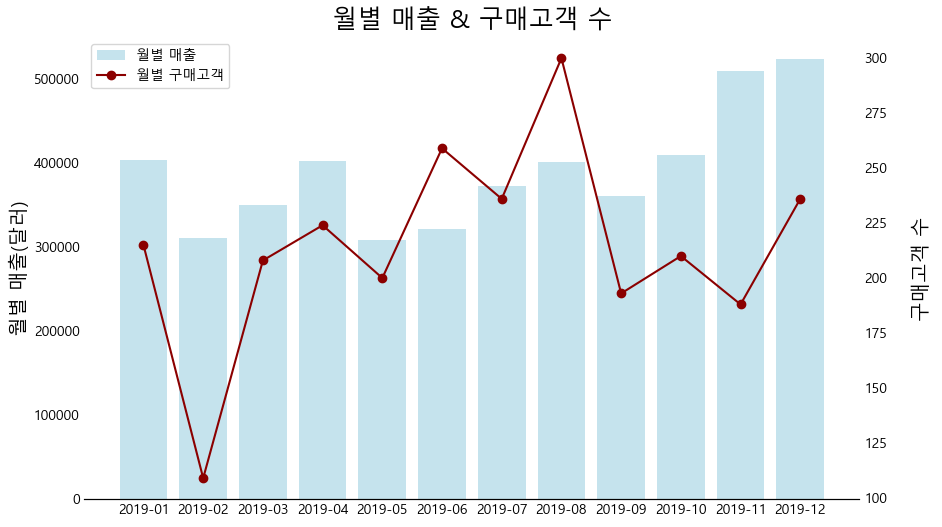

> 구매 발생일이 4일 이상인 고객들

In [23]:
buy_map[buy_map['총거래일'] >= 4]

거래월,1,2,3,4,5,6,7,8,9,10,11,12,총거래일
CustomerID,,,,,,,,,,,,,
USER_0009,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,4.0
USER_0025,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0
USER_0033,1.0,0.0,0.0,2.0,0.0,1.0,3.0,2.0,0.0,1.0,0.0,1.0,11.0
USER_0035,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,6.0
USER_0039,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER_1430,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,6.0
USER_1432,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0
USER_1433,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0


In [24]:
sales[sales['CustomerID'] == 'USER_0033'].sort_values(by='TransactionDate').tail(20)

,CustomerID,TransactionID,TransactionDate,ProductID,ProductCategory,Quantity,AverageAmount,ShippingFee,CouponStatus
17051,USER_0033,Transaction_15746,2019-08-28,Product_0299,Apparel,1,4.56,6.00,Clicked
25790,USER_0033,Transaction_19550,2019-10-23,Product_0708,Apparel,1,13.92,6.00,Clicked
25791,USER_0033,Transaction_19550,2019-10-23,Product_0930,Office,1,1.59,6.00,Used
25792,USER_0033,Transaction_19550,2019-10-23,Product_0983,Nest-USA,2,119.00,6.00,Not Used
34490,USER_0033,Transaction_23911,2019-12-16,Product_0983,Nest-USA,1,121.30,12.99,Used
34493,USER_0033,Transaction_23914,2019-12-16,Product_0981,Nest-USA,2,151.88,6.50,Clicked
34494,USER_0033,Transaction_23914,2019-12-16,Product_0985,Nest-USA,5,80.52,6.50,Clicked
34495,USER_0033,Transaction_23915,2019-12-16,Product_0648,Headgear,1,20.38,6.00,Clicked
34496,USER_0033,Transaction_23916,2019-12-16,Product_0983,Nest-USA,2,121.30,6.50,Used
34497,USER_0033,Transaction_23917,2019-12-16,Product_0983,Nest-USA,2,121.30,19.99,Used


- USER_0033은 평균 2달에 1번 꼴로 장기간에 걸쳐 구매를 지속. 6~8월 샵을 더 많이 방문

#### 구매 제품 종류, 재구매_제품비율

In [25]:
sql = '''
SELECT
    CustomerID,
    ProductID,
    SUM(Quantity) AS 구매개수,
    COUNT(*) AS 제품구매횟수
FROM
    sales
GROUP BY 
    CustomerID, ProductID
ORDER BY
    CustomerID, ProductID
;
'''

product_purchase = show_sql_result(sql)
product_purchase

,CustomerID,ProductID,구매개수,제품구매횟수
0,USER_0000,Product_0048,1,1
1,USER_0000,Product_0946,2,1
2,USER_0001,Product_0104,1,1
3,USER_0001,Product_0182,1,1
4,USER_0001,Product_0195,3,1
...,...,...,...,...
37660,USER_1467,Product_1052,1,1
37661,USER_1467,Product_1096,2,2
37662,USER_1467,Product_1133,1,1
37663,USER_1467,Product_1134,2,2


In [26]:
product_purchase['재구매여부'] = product_purchase['제품구매횟수'].apply(lambda x: 1 if x > 1 else 0)
customer_repurchase_rate = product_purchase.groupby('CustomerID', as_index=False)['재구매여부'].mean()
customer_repurchase_rate['재구매여부'] = round(customer_repurchase_rate['재구매여부'], 3)
customer_repurchase_rate = customer_repurchase_rate.rename(columns={'재구매여부': '재구매_제품비율'}).copy()
customer_repurchase_rate

,CustomerID,재구매_제품비율
0,USER_0000,0.000
1,USER_0001,0.262
2,USER_0002,0.095
3,USER_0003,0.545
4,USER_0004,0.091
...,...,...
1463,USER_1463,0.000
1464,USER_1464,0.143
1465,USER_1465,0.000
1466,USER_1466,0.000


In [27]:
customer_repurchase_rate.describe()

,재구매_제품비율
count,1468.000000
mean,0.139443
std,0.129203
min,0.000000
25%,0.000000
50%,0.130000
75%,0.216250
max,0.800000


- 일부 고객의 재구매 비율이 높지만, 단발성 거래를 하는 고객이 많아 평균이 낮게 나올 것으로 추측

In [28]:
customer_product_count = product_purchase.groupby('CustomerID', as_index=False)[['ProductID']].size().rename(columns={'size': '구매제품종류'})
customer_product_count

,CustomerID,구매제품종류
0,USER_0000,2
1,USER_0001,42
2,USER_0002,21
3,USER_0003,11
4,USER_0004,33
...,...,...
1463,USER_1463,7
1464,USER_1464,35
1465,USER_1465,8
1466,USER_1466,1


#### 번외) 재구매_제품

In [29]:
product_purchase['재구매여부'] = product_purchase['제품구매횟수'].apply(lambda x: 1 if x > 1 else 0)
product_view = product_purchase.groupby('ProductID',as_index=False)['재구매여부'].sum().rename(columns={'재구매여부':'재구매_고객수'}).copy()
product_view

,ProductID,재구매_고객수
0,Product_0000,2
1,Product_0001,0
2,Product_0002,3
3,Product_0003,1
4,Product_0004,0
...,...,...
1140,Product_1140,0
1141,Product_1141,2
1142,Product_1142,1
1143,Product_1143,12


In [30]:
product_view.sort_values(by='재구매_고객수', ascending=False)

,ProductID,재구매_고객수
983,Product_0983,658
981,Product_0981,652
976,Product_0976,634
984,Product_0984,314
989,Product_0989,263
...,...,...
502,Product_0502,0
503,Product_0503,0
504,Product_0504,0
505,Product_0505,0


In [31]:
product_view.describe(percentiles=[0, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99])

,재구매_고객수
count,1145.000000
mean,6.075983
std,38.215807
min,0.000000
0%,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
80%,3.000000
90%,7.000000


In [33]:
product_view[product_view['재구매_고객수']==0]

,ProductID,재구매_고객수
1,Product_0001,0
4,Product_0004,0
5,Product_0005,0
6,Product_0006,0
9,Product_0009,0
...,...,...
1124,Product_1124,0
1125,Product_1125,0
1126,Product_1126,0
1140,Product_1140,0


- 재구매가 없는 제품이 다수(제품의 55.6%는 재구매가 없었음)
- 고객들의 재구매는 일부 제품에 집중되어 있음

In [44]:
# 재구매 상위 5% 제품
top_prodcut = product_view.loc[product_view['재구매_고객수'] > 17].sort_values(by='재구매_고객수', ascending=False)
top_prodcut

,ProductID,재구매_고객수
983,Product_0983,658
981,Product_0981,652
976,Product_0976,634
984,Product_0984,314
989,Product_0989,263
...,...,...
295,Product_0295,20
535,Product_0535,19
966,Product_0966,19
951,Product_0951,19


In [43]:
sql = '''
SELECT
    *
FROM
    product
;
'''

product = show_sql_result(sql)
product

,ProductID,ProductCategory
0,Product_0182,Accessories
1,Product_0183,Accessories
2,Product_0856,Accessories
3,Product_0857,Accessories
4,Product_0871,Accessories
...,...,...
1140,Product_1017,Waze
1141,Product_1018,Waze
1142,Product_1019,Waze
1143,Product_1020,Waze


In [51]:
df_product = pd.merge(left=top_prodcut, right=product, on='ProductID')[['ProductID', 'ProductCategory', '재구매_고객수']]
df_product

,ProductID,ProductCategory,재구매_고객수
0,Product_0983,Nest-USA,658
1,Product_0981,Nest-USA,652
2,Product_0976,Nest-USA,634
3,Product_0984,Nest-USA,314
4,Product_0989,Nest-USA,263
...,...,...,...
53,Product_0295,Apparel,20
54,Product_0535,Apparel,19
55,Product_0966,Office,19
56,Product_0951,Office,19


In [56]:
# 재구매가 많은 제품들
df_product['ProductCategory'].value_counts()

ProductCategory
Office       16
Apparel      11
Drinkware     8
Nest-USA      7
Lifestyle     6
Nest          4
Bags          4
Headgear      1
Waze          1
Name: count, dtype: int64

- 상위 5개 항목은 기본적으로 제품 판매가 많았던 카테고리들
    - 판매량이 많고 매출 비율이 높았던 제품들은 재구매가 많았던 제품들
- 최상위권은 Nest-USA

In [32]:
# mycursor.close()
# conn.close()